In [134]:
# Import necessary libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from fancyimpute import KNN
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve

In [135]:
df_final = pd.read_csv(r"C:\HOC\khoaluan\final_data.csv")

In [136]:
df_final

,Loan Loss Provisions,Total Deposits Ratio,Non-Interest Expenses,Loan Loss Provisions Ratio,Cumulative Gaps Over Total Assets,Profits Before Tax,Target
0,2887292.375,0.068268,9.287076e+05,2.632933,31.937059,2.153334e+05,1.0
1,2887292.375,0.068268,6.501660e+05,2.632933,60.461667,2.737330e+05,1.0
2,37857.000,0.009918,4.455200e+04,1.996342,46.218506,5.342000e+03,1.0
3,650476.000,0.068268,4.447170e+05,2.220420,55.087241,3.289510e+05,1.0
4,13372.000,0.040645,1.351380e+05,0.342156,78.886473,1.646510e+05,0.0
...,...,...,...,...,...,...,...
609,2887292.375,0.021924,5.511766e+06,1.509858,61.588354,3.620859e+06,1.0
610,2400324.000,0.021140,6.120005e+06,1.191129,16.278227,5.363616e+06,0.0
611,2887292.375,0.038337,6.223097e+06,1.075502,73.473452,5.363616e+06,0.0
612,2887292.375,0.046856,6.223097e+06,2.408904,29.649680,5.363616e+06,0.0


In [137]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(['Target'], axis=1), df_final["Target"], test_size=0.2 , random_state= 38 )
# Split the remaining 70% into 90% training and 10% validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=38)


In [138]:
from sklearn.preprocessing import StandardScaler

# initialize StandardScaler object
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
# fit and transform the data
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)


In [139]:
# create a new dataframe with the scaled data
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

### Feature Importance

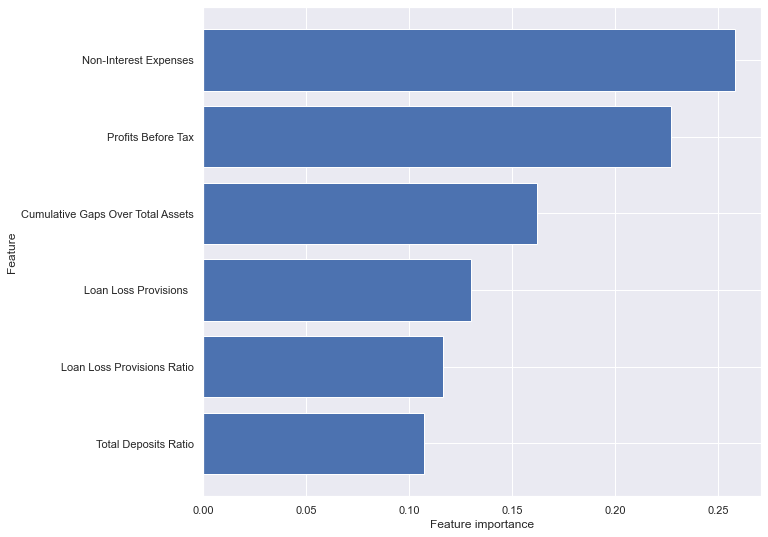

In [140]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,9)})

X = df_final.drop(['Target'], axis=1)
y = df_final['Target']


# Fit the decision tree classifier to the data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)

# Get the feature importances from the classifier
importances = clf.feature_importances_

# Sort the features by their importance
sorted_indices = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_indices])
plt.yticks(range(X.shape[1]), X.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [141]:
# Get the feature importances from the classifier and create a dataframe
importances = clf.feature_importances_
df_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance in ascending order
df_importances_sorted = df_importances.sort_values('Importance', ascending=False)

# Print the sorted dataframe
print(df_importances_sorted)

                             Feature  Importance
2              Non-Interest Expenses    0.258069
5                 Profits Before Tax    0.227234
4  Cumulative Gaps Over Total Assets    0.161881
0             Loan Loss Provisions      0.129696
3         Loan Loss Provisions Ratio    0.116148
1               Total Deposits Ratio    0.106973


In [142]:
df_importances_sorted.to_csv('ft_importance.csv', index=False)

In [143]:
# List of features used to build models because feature_importance > 0
features = df_importances[df_importances['Importance'] > 0]['Feature'].tolist()
# Add the target variable to the list of features
features.append("Target")

len(features)

7

## Baseline model

In [144]:
def baseline_model(X_train, y_train, X_test, y_test):
    baseline = LogisticRegression(random_state=38)
    baseline.fit(X_train, y_train)

    # predict on test set
    y_pred_baseline = baseline.predict(X_test)

    # print evaluation metrics
    print("\nLogistic regression:")
    print(confusion_matrix(y_test, y_pred_baseline))
    print(classification_report(y_test, y_pred_baseline))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, cmap="Blues", fmt="d",
                    xticklabels=["0", "1"],
                    yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # predict probabilities for test set
    y_pred_prob_baseline = baseline.predict_proba(X_test)[:, 1]

    # calculate ROC-AUC score
    roc_auc_baseline = roc_auc_score(y_test, y_pred_prob_baseline)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_baseline)
    plt.plot(fpr, tpr, label='Baseline model (AUC = {:.2f})'.format(roc_auc_baseline))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return baseline



Logistic regression:
[[65 18]
 [15 25]]
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80        83
         1.0       0.58      0.62      0.60        40

    accuracy                           0.73       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.74      0.73      0.73       123



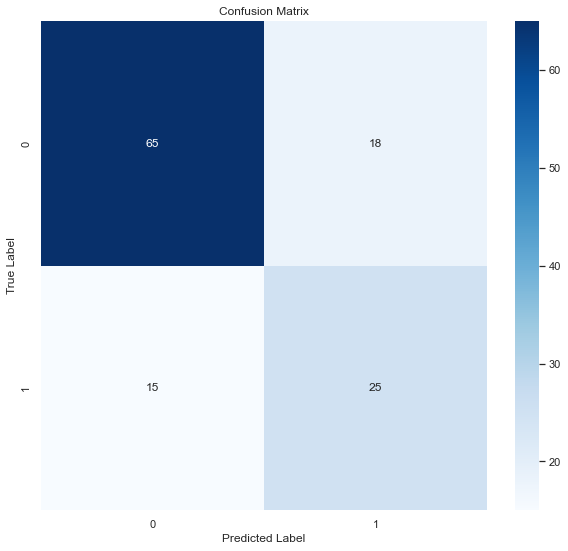

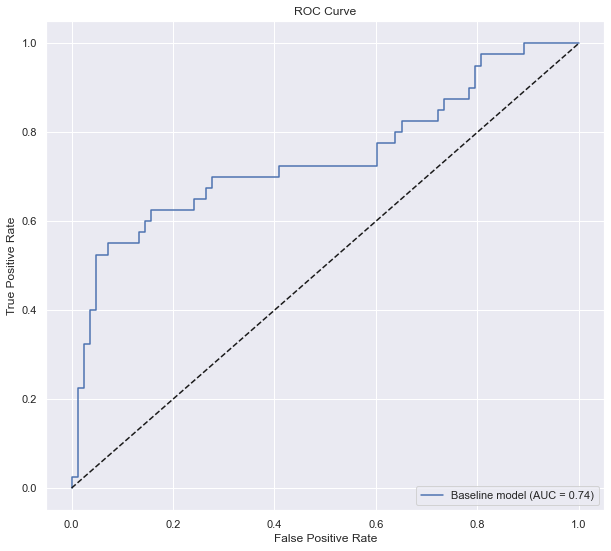

LogisticRegression(random_state=38)

In [145]:
baseline_model(X_train, y_train, X_test, y_test)

Logistic Regression

In [146]:
def logistic_regression_tuning(X_train, y_train, X_test, y_test):
    # define parameter grid
    param_grid = {'penalty': ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'solver': ['liblinear', 'saga']}

    # create grid search object
    grid = GridSearchCV(LogisticRegression(random_state=38), param_grid, cv=5, scoring = "recall")

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # print results
    print("Best parameters: ", grid.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))

    # use best parameters to fit model to data
    lr = grid.best_estimator_
    lr.fit(X_train, y_train)

    # predict on test set
    y_pred_lr = lr.predict(X_test)

    # print evaluation metrics
    print("\nLogistic regression:")
    print(confusion_matrix(y_test, y_pred_lr))
    print(classification_report(y_test, y_pred_lr))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, cmap="Blues", fmt="d",
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # predict probabilities for test set
    y_pred_prob_lr = lr.predict_proba(X_test)[:, 1]

    # calculate ROC-AUC score
    roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return lr


Best parameters:  {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.72

Logistic regression:
[[65 18]
 [15 25]]
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80        83
         1.0       0.58      0.62      0.60        40

    accuracy                           0.73       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.74      0.73      0.73       123



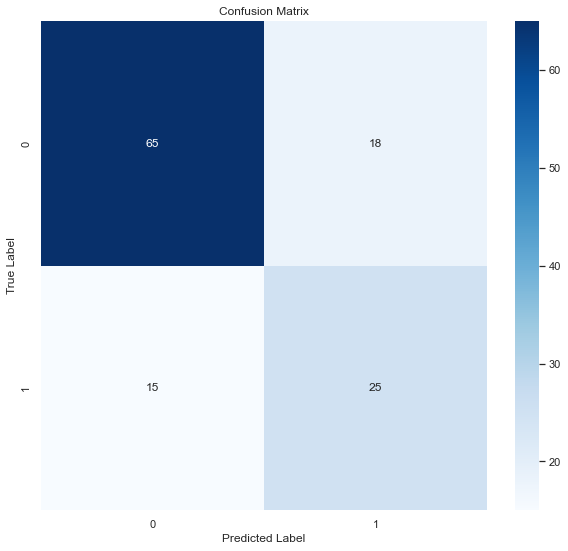

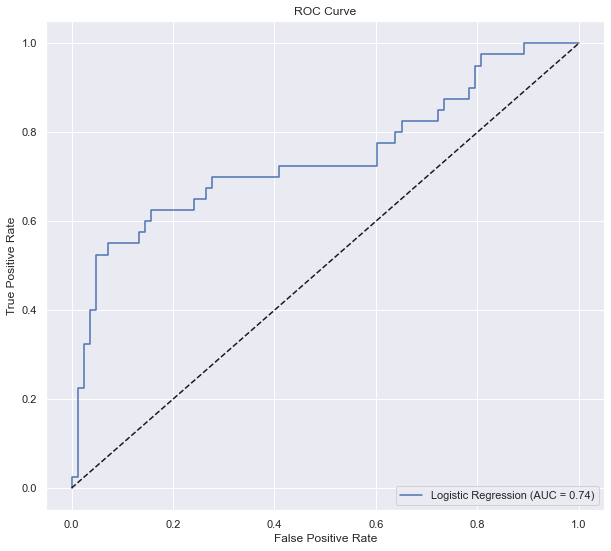

LogisticRegression(C=0.001, penalty='l1', random_state=38, solver='saga')

In [147]:
logistic_regression_tuning(X_train, y_train, X_test, y_test)

In [148]:
# logistic_regression_tuning(X_train, y_train, X_val, y_val)

### SVM

In [149]:
def svm_tuning(X_train, y_train, X_test, y_test):
    # define parameter grid
    param_grid = {'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]}
    # create grid search object
    grid = GridSearchCV(SVC(random_state=38, probability= True), param_grid, cv=5, scoring = "recall")

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # print results
    print("Best parameters: ", grid.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))

    # use best parameters to fit model to data
    svm = grid.best_estimator_
    svm.fit(X_train, y_train)

    # predict on test set
    y_pred_svm = svm.predict(X_test)

    # print evaluation metrics
    print("\nSVM:")
    print(confusion_matrix(y_test, y_pred_svm))
    print(classification_report(y_test, y_pred_svm))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt="d",
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # predict probabilities for test set
    y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]

    # calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob_svm)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svm)
    plt.plot(fpr, tpr, label='SVM (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return svm

Best parameters:  {'C': 100, 'degree': 2, 'kernel': 'rbf'}
Best cross-validation score: 0.71

SVM:
[[74  9]
 [13 27]]
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        83
         1.0       0.75      0.68      0.71        40

    accuracy                           0.82       123
   macro avg       0.80      0.78      0.79       123
weighted avg       0.82      0.82      0.82       123



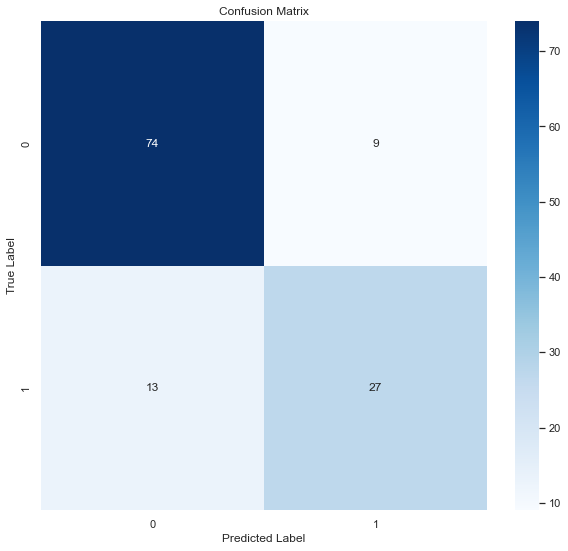

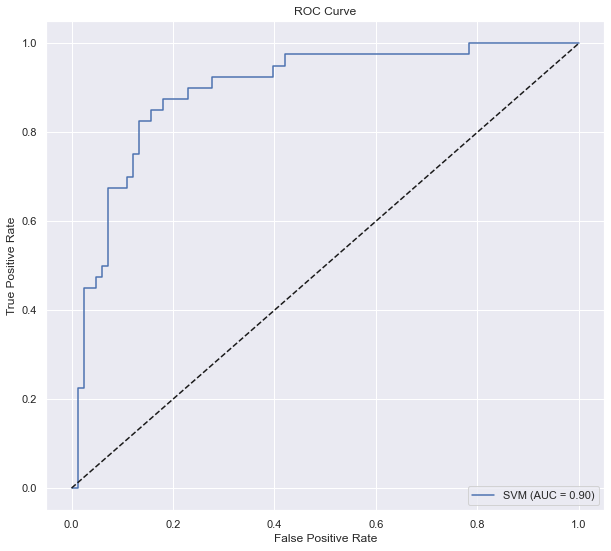

SVC(C=100, degree=2, probability=True, random_state=38)

In [150]:
svm_tuning(X_train_scaled, y_train, X_test_scaled, y_test)

### Adaboost

In [151]:
def adaboost_tuning(X_train, y_train, X_test, y_test):
    # define parameter grid
    param_grid = {'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1]}
    # create grid search object
    grid = GridSearchCV(AdaBoostClassifier(random_state=38), param_grid, cv=5, scoring = "recall")

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # print results
    print("Best parameters: ", grid.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))

    # use best parameters to fit model to data
    ada = grid.best_estimator_
    ada.fit(X_train, y_train)

    # predict on test set
    y_pred_ada = ada.predict(X_test)

    # print evaluation metrics
    print("\nAdaboost:")
    print(confusion_matrix(y_test, y_pred_ada))
    print(classification_report(y_test, y_pred_ada))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, cmap="Blues", fmt="d",
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # predict probabilities for test set
    y_pred_prob_ada = ada.predict_proba(X_test)[:, 1]

    # calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob_ada)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ada)
    plt.plot(fpr, tpr, label='ADA (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return ada

Best parameters:  {'learning_rate': 1, 'n_estimators': 200}
Best cross-validation score: 0.65

Adaboost:
[[69 14]
 [18 22]]
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        83
         1.0       0.61      0.55      0.58        40

    accuracy                           0.74       123
   macro avg       0.70      0.69      0.70       123
weighted avg       0.73      0.74      0.74       123



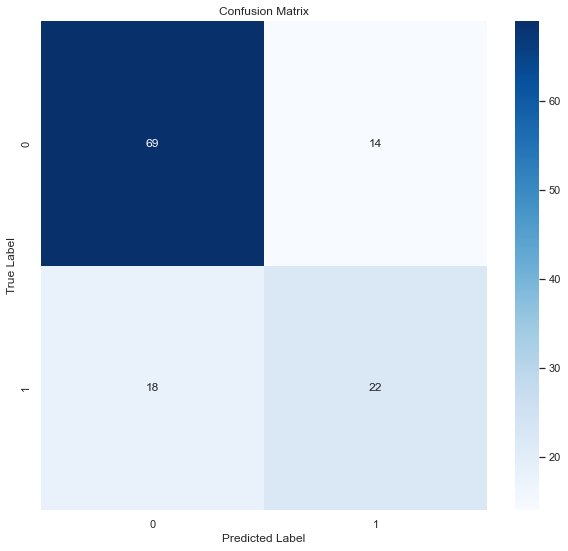

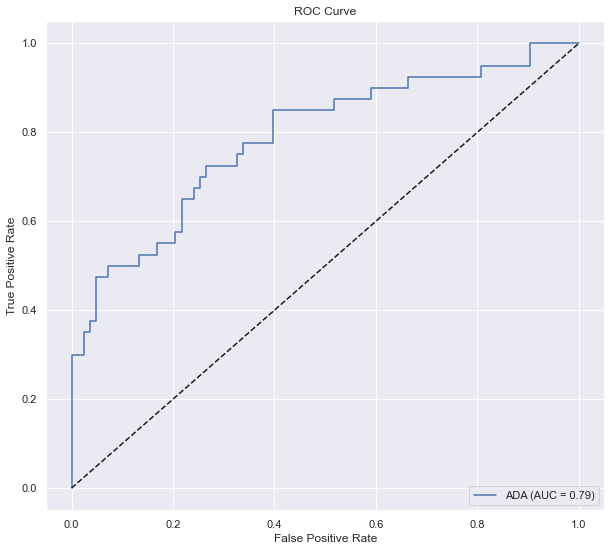

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=38)

In [152]:
adaboost_tuning(X_train_scaled, y_train, X_test_scaled, y_test)

In [153]:
def f1(X_train, y_train, X_test):
    # define parameter grid
    param_grid = {'penalty': ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'solver': ['liblinear', 'saga']}

    # create grid search object
    grid = GridSearchCV(LogisticRegression(random_state=38), param_grid, cv=5, scoring='recall')

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # use best parameters to fit model to data
    lr = grid.best_estimator_
    lr.fit(X_train, y_train)

    # predict probabilities for test set
    y_pred_prob_lr = lr.predict_proba(X_test)[:, 1]
    return y_pred_prob_lr

def f2(X_train, y_train, X_test):
    # define parameter grid
    param_grid = {'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]}
    # create grid search object
    grid = GridSearchCV(SVC(random_state=38, probability= True), param_grid, cv=5, scoring='recall')

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # use best parameters to fit model to data
    svm = grid.best_estimator_
    svm.fit(X_train, y_train)

    # predict probabilities for test set
    y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]
    return y_pred_prob_svm

def f3(X_train, y_train, X_test):
    # define parameter grid
    param_grid = {'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1]}
    # create grid search object
    grid = GridSearchCV(AdaBoostClassifier(random_state=38), param_grid, cv=5, scoring='recall')

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # use best parameters to fit model to data
    ada = grid.best_estimator_
    ada.fit(X_train, y_train)

    # predict probabilities for test set
    y_pred_prob_ada = ada.predict_proba(X_test)[:, 1]
    return y_pred_prob_ada



y_pred_prob_lr = f1(X_train, y_train, X_test)
y_pred_prob_svm = f2(X_train_scaled, y_train, X_test_scaled)
y_pred_prob_ada = f3(X_train_scaled, y_train, X_test_scaled)

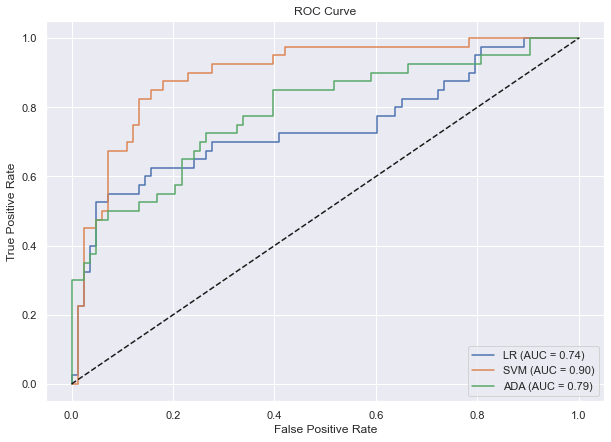

In [154]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))
# calculate ROC-AUC scores for all three models
roc_auc_lr = roc_auc_score(y_test,y_pred_prob_lr  )
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)
roc_auc_ada = roc_auc_score(y_test, y_pred_prob_ada)

# plot ROC curves for all three models on the same plot
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr )
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_prob_svm)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_prob_ada)

plt.plot(fpr_lr, tpr_lr, label='LR (AUC = {:.2f})'.format(roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot(fpr_ada, tpr_ada, label='ADA (AUC = {:.2f})'.format(roc_auc_ada))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

